In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math 

import qiskit
from qiskit import IBMQ, BasicAer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

/tmp/ipykernel_8018/2415834068.py:6: DeprecationWarning: BasicAer is deprecated since Qiskit 0.46 and will be removed in Qiskit 1.0. The BasicAer (qiskit.providers.basicaer) module has been superseded by  qiskit.providers.basic_provider, and all its classes have been renamed to follow a new naming convention. More information and migration guidelines can be found in the 0.46 API docs for BasicAer.
  from qiskit import IBMQ, BasicAer, transpile, execute


# Anwendungsbeispiel mit 3-SAT

Um später den Grover Algorithmus zu umschreiben, verwenden wir im folgenden eine besondere Form des 3-SAT Problems. Betrachten wir eine Boolesche Funktion $(f)$ mit den drei Booleschen Variablen $(x_1)$, $(x_2)$, $(x_3)$, wie unten dargestellt:

$$
f(x_1, x_2, x_3) = (x_1 \lor x_2 \lor \neg x_3) \land (\neg x_1 \lor \neg x_2 \lor \neg x_3) \land (\neg x_1 \lor x_2 \lor x_3)
$$

Die Boolesche Funktion $(f)$ ist erfüllbar, wenn es eine Belegung von $(x_1)$, $(x_2)$, $(x_3)$ gibt, sodass $(f(x_1, x_2, x_3) = 1)$ (oder $(f)$ zu Wahr evaluiert). Unser Problem verlangt zusätzlich, dass wir eine Belegung finden, sodass $(f = 1)$ (oder Wahr) ist und es in jeder Klausel von $(f)$ genau ein Literal gibt, das zu Wahr evaluiert.

Eine naive Methode, um eine solche Belegung zu finden, besteht darin, jede mögliche Kombination von Eingabewerten von $(f)$ auszuprobieren. Die untenstehende Tabelle zeigt alle möglichen Kombinationen von $(x_1)$, $(x_2)$, $(x_3)$.

| $(x_1)$ | $(x_2)$ | $(x_3)$ | $(f)$ | Kommentar |
|:---:|:---:|:---:|:---:|:---|
| 0 | 0 | 0 | 1 | Keine Lösung, da es drei wahre Literale in der zweiten Klausel gibt |
| 0 | 0 | 1 | 0 | Keine Lösung, da $(f)$ Falsch ist |
| 0 | 1 | 0 | 1 | Keine Lösung, da es zwei wahre Literale in der ersten Klausel gibt |
| 0 | 1 | 1 | 0 | Keine Lösung, da es drei wahre Literale in der dritten Klausel gibt |
| 1 | 0 | 0 | 0 | Keine Lösung, da $(f)$ Falsch ist |
| 1 | 0 | 1 | **1** | **Lösung** |
| 1 | 1 | 0 | 1 | Keine Lösung, da es drei wahre Literale in der ersten Klausel gibt |
| 1 | 1 | 1 | 0 | Keine Lösung, da $(f)$ Falsch ist |

# Orakel und Phasenmarkierung

Als nächstes müssen wir einen Schaltkreis konstruieren, der die SAT Konfiguration überprüft. Dieser Schaltkreis kann dann als Blackbox (oder Orakel) in der Grover-Suche verwendet werden. Um die Blackbox zu entwerfen, müssen wir die Lösung des Problems nicht im Voraus kennen: Es reicht aus, eine Blackbox zu entwerfen, die überprüft, ob die Zuweisung dazu führt, dass $(f)$ zu Wahr oder Falsch evaluiert.

Für jede Klausel von $(f)$ entwerfen wir einen Sub-Schaltkreis, der genau dann Wahr ausgibt, wenn genau ein Literal in der Klausel Wahr ist. Indem wir alle Sub-Schaltkreise für alle Klauseln kombinieren, können wir dann die Blackbox erhalten, die genau dann Wahr ausgibt, wenn alle Klauseln mit genau einem wahren Literal erfüllt sind.

Betrachten wir zum Beispiel die Klausel $(x_1 \lor \neg x_2 \lor x_3)$. So ist $(y)$ wie folgt definiert:

$$
y = x_1 \oplus \neg x_2 \oplus x_3 \oplus (x_1 \land \neg x_2 \land x_3)
$$

und nur dann Wahr, wenn genau eines von $( x_1 )$, $( \neg x_2 )$ und $( x_3 )$ Wahr ist. Unter Verwendung von zwei Arbeits-Qubits kann $( y )$ durch den folgenden Sub-Schaltkreis berechnet werden. Im Folgenden wird $( x_1 x_2 x_3 )$ in $( q_1 q_2 q_3 )$ umbenannt, $( q_4 )$ wird als Arbeits-Qubit verwendet, und $( q_5 )$ wird verwendet, um den Wert von $( y )$ zu speichern.

In [10]:
r = QuantumRegister(6)
qc = QuantumCircuit(r)
qc.x(r[2])
qc.cx(r[1], r[5])
qc.cx(r[2], r[5])
qc.cx(r[3], r[5])
qc.ccx(r[1], r[2], r[4])
qc.ccx(r[3], r[4], r[5])
qc.ccx(r[1], r[2], r[4])
qc.x(r[2])
qc.draw()

q3_0: ────────────────────────────────────────
                                              
q3_1: ───────■──────────────■─────────■───────
      ┌───┐  │              │         │  ┌───┐
q3_2: ┤ X ├──┼────■─────────■─────────■──┤ X ├
      └───┘  │    │         │         │  └───┘
q3_3: ───────┼────┼────■────┼────■────┼───────
             │    │    │  ┌─┴─┐  │  ┌─┴─┐     
q3_4: ───────┼────┼────┼──┤ X ├──■──┤ X ├─────
           ┌─┴─┐┌─┴─┐┌─┴─┐└───┘┌─┴─┐└───┘     
q3_5: ─────┤ X ├┤ X ├┤ X ├─────┤ X ├──────────
           └───┘└───┘└───┘     └───┘

Im obigen Sub-Schaltkreis werden die drei `ccx`-Gatter auf der rechten Seite verwendet, um $( q_1 \land \neg q_2 \land q_3 )$ zu berechnen und das Ergebnis in $( q_5 )$ zu schreiben, während die drei `cx`-Gatter auf der linken Seite verwendet werden, um $( q_1 \oplus \neg q_2 \oplus q_3 )$ zu berechnen und das Ergebnis in $( q_5 )$ zu schreiben. Beachte, dass das ganz rechte `ccx`-Gatter verwendet wird, um den Wert von $( q_4 )$ zurückzusetzen, damit es in den nachfolgenden Sub-Schaltkreisen wiederverwendet werden kann.

In [11]:
def black_box(circuit, f_in, f_out, aux, n, sat_formula):
    # Anzahl der Klauseln in der 1-3-SAT-Formel bestimmen
    num_clauses = len(sat_formula)
    
    for (k, clause) in enumerate(sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        
        # Anwenden von ccx Gattern zur Verknüpfung mehrerer Qubits
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        
        # Rückgängig machen des X-Gatters für negative Literale, um den ursprünglichen Zustand wiederherzustellen
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])

    # Nach der Verarbeitung aller Klauseln entscheidet der folgende Block,
    # wie das Ergebnis in das Ausgaberegister f_out[0] geschrieben wird
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('Only 3 Clauses allowed')

    # Zweite Schleife: Diese Schleife wiederholt den Vorgang aus der ersten Schleife,
    # um den angewendeten Zustand auf den Qubits rückgängig zu machen
    for (k, clause) in enumerate(sat_formula):
        for literal in clause:
            if literal > 0:
                # Rückgängig machen der CNOT-Gatter für positive Literale
                circuit.cx(f_in[literal-1], aux[k])
            else:
                # Rückgängig machen der X- und CNOT-Gatter für negative Literale
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])

        # Wiederherstellung des ursprünglichen Zustands der negativen Literale
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])


## Inversion

Der nächste Schritt der Grover Iteration ist die Durchführung der *Inversion-über-dem-Durchschnitt*. Diese Technik verändert alle Wahrscheinlichkeiten der möglichen Lösungen, sodass die Wahrscheinlichkeit für die richtige Lösung größer wird. Dabei wird folgende Transformation durchgeführt:

$$
\sum_{j=0}^{2^n-1} \alpha_j |j\rangle \rightarrow \sum_{j=0}^{2^n-1} \left( 2 \left( \frac{1}{2^n} \sum_{k=0}^{2^n-1} \alpha_k \right) - \alpha_j \right) |j\rangle
$$

Diese Transformation kann verwendet werden, um die Wahrscheinlichkeitsamplitude $( \alpha_s )$ zu verstärken, wenn $( s )$ die Lösung ist und $( \alpha_s )$ klein und negativ ist. Gleichzeitig sind $( \alpha_j )$ für $( j \neq s )$ positiv. Einfach gesagt, der Wert von $( \alpha_s )$ wird um das Doppelte des Durchschnittswerts aller Amplituden erhöht, während die anderen Amplituden reduziert werden.

Diese Rechnung kann mit der folgenden Sequenz unitärer Matrizen realisiert werden:

$$
H^{\otimes n} \left(2|0\rangle \langle 0 | - I\right) H^{\otimes n}
$$

Die Hadamard-Gatter $( H )$, die am Anfang und Ende der Sequenz stehen, werden auf jedes Qubit angewendet und verteilen die Zustände gleichmäßig. Die Operation in der Mitte sorgt dafür, dass die Amplitude des Zustands, der der binären Zeichenkette "000..." entspricht, umgekehrt wird.

Dieser Sub-Schaltkreis kann durch eine sogenannte Multi-Qubit-Controlled-Z-Operation realisiert werden, die die Amplitude des Zustands umkehrt, der der binären Zeichenkette "111..." entspricht. Durch das Anwenden von X-Gattern auf alle Qubits vor und nach der Funktion realisieren wir den gewünschten Sub-Schaltkreis.

In [12]:
def n_controlled_Z(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)


In [13]:
def inversion_about_average(circuit, f_in, n):
    for j in range(n):
        circuit.h(f_in[j])
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    for j in range(n):
        circuit.h(f_in[j])


Eine Beispielhafte Schaltung einer solchen Inversion mit 3 Qubits sieht wie folgt aus:

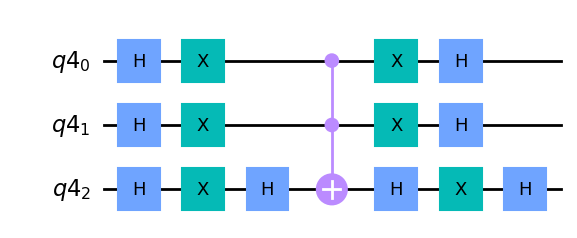

In [14]:
qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)
inversion_about_average(qInvAvg, qr, 3)
qInvAvg.draw(output='mpl')

## Grover-Algorithmus: einmal komplett

Eine Vollständige Durchführung des Grover-Algorithmus sieht wie folgt aus

1. Versetze die Qubits in eine Superposition aus allen möglichen Lösungen als Anfangszustand (die Arbeits-Qubits starten mit dem Wert Null):

$$
\sum_{j=0}^{2^n-1} \frac{1}{2^n} |j\rangle |0\rangle
$$

2. Wiederhole den folgenden Schritt $( T )$ mal (mit $T =\sqrt{N}$ erhält man die höchste Wahrscheinlichkeit den gewollten Zustand zu messen):

    - Wende die Blackbox-Funktion an (diese dient als Orakel und markiert die gesuchte Lösung)
    - Führe die *Umkehrung und die Rotation* aus (dies verstärkt die Wahrscheinlichkeit für die richtige Lösung)

3. Zustand messen

/tmp/ipykernel_8018/1922925492.py:37: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute([grover], backend=backend, shots=1000)


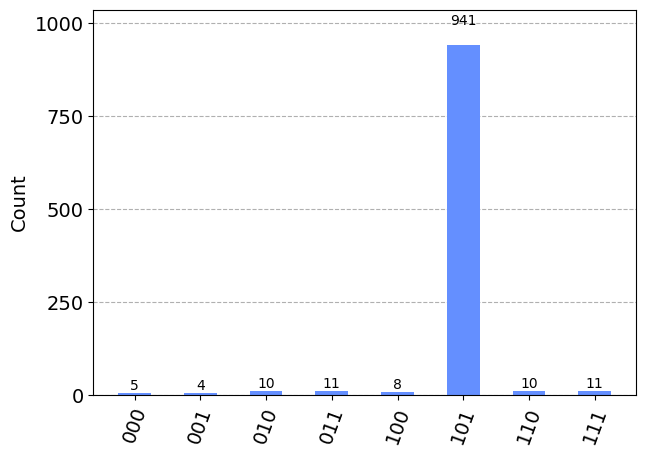

In [15]:
def input_state(circuit, f_in, f_out, n):
    # Erzeuge eine Superposition der Eingangsqubits durch Hadamard-Gatter auf jedes f_in-Qubit
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
n = 3

sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Quantenregister und Hilfsregister
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(sat_formula) + 1)

ans = ClassicalRegister(n)

# Grover Schaltkreis
grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

input_state(grover, f_in, f_out, n)
T = 2
for t in range(T):
    black_box(grover, f_in, f_out, aux, n, sat_formula)
    inversion_about_average(grover, f_in, n)

# Zustant der Eingangs-Qubits
for j in range(n):
    grover.measure(f_in[j], ans[j])

# Simualation der Schaltung
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=1000)
result = job.result()

counts = result.get_counts(grover)
plot_histogram(counts)